Using Age, Experience, and Played Hours to Predict Minecraft Newsletter Subcription Status
-

**DSCI 100 010 Group 6** 

**Sayyam Arora, Michael Dickinson, Cecile Nava, Zoey Qiu** 

In [1]:
# Run
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

PLAYERS_DATA_URL = "https://raw.githubusercontent.com/Michael-R-Dickinson/DSCI-100-individual-project/refs/heads/main/players.csv"

# Download Data
download.file(PLAYERS_DATA_URL, "players.csv")

# Load Data
players_df <- read_csv('players.csv') 

# Clean Data

# Remove NA's and add levels to experience for visualization
players_df <- players_df |>
    filter(!is.na(Age)) |>
    mutate(
        "age" = Age,
        "subscribe" = as.factor(subscribe),
        "hashed_email" = hashedEmail,
        "experience" = factor(
            experience, 
            levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"), 
        )
    ) |>
    select(-Age, -hashedEmail)

head(players_df)


players_df <- players_df |>
    mutate("experience" = as.numeric(experience))


players_datasets <- initial_split(players_df, prop = 0.8, strata = subscribe)
train_set <- training(players_datasets)
test_set <- testing(players_datasets)

folds <- vfold_cv(data = train_set, v = 5, strata = subscribe)

classification_recipe <- recipe(subscribe ~ played_hours + age + experience, data = players_df) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

tune_grid <- tibble(neighbors = seq(from = 1, to = 30, by = 1))
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

classification_workflow <- workflow() |>
    add_recipe(classification_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = folds, grid = tune_grid)

metrics <- classification_workflow |> collect_metrics()

accuracies <- metrics |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

accuracy_by_neighbors_plot <- accuracies |> ggplot(aes(x = neighbors, y = mean)) +
    geom_line() + 
    geom_point() +
    labs(
        x = "Number of Neighbors", 
        y = "Cross Validation Accuracy",
        title = "Accuracy vs Number of Neighbors"
    ) + 
    theme(text = element_text(size = 20))

optimal_number_of_neighbors <- accuracies |>
    arrange(order_by = desc(mean)) |>
    slice(1) |>
    pull(neighbors)

optimal_knn_spec <-  nearest_neighbor(weight_func = "rectangular", neighbors = optimal_number_of_neighbors) |>
    set_engine("kknn") |>
    set_mode("classification")

optimal_workflow <- workflow() |>
    add_recipe(classification_recipe) |>
    add_model(optimal_knn_spec) |>
    fit(data = train_set)

test_set_metrics <- optimal_workflow |>
    predict(test_set) |>
    bind_cols(test_set) |>
    metrics(truth = subscribe, estimate = .pred_class)

predictors_df <- players_df |> 
    select(played_hours, age, experience, subscribe)

# Histograms with Subscribe coloring for analyzing visualization

# for played hours 
options(repr.plot.width = 8, repr.plot.height = 6)
hours_his <- predictors_df |> ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram(bins = 12) +
    scale_x_log10() + 
    labs(
            x = "Hours Played",
            y = "Number of Players",
            fill = "Subscribed",
            title = "Played Hours Colored by Subscription"
    ) + 
    theme(text = element_text(size = 15))

# for age
options(repr.plot.width = 8, repr.plot.height = 6)
age_his <- predictors_df |> ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram(bins = 12) +
    labs(
            x = "Player Age",
            y = "Number of Players",
            fill = "Subscribed",
            title = "Player Age Colored by Subscription"
    ) + 
    # Log scaling on y but without dropping all rows that cause 0 values
    # because log(0) = infinity
    scale_y_continuous(trans = scales::pseudo_log_trans()) + 
    theme(text = element_text(size = 15))

# for experience
options(repr.plot.width = 8, repr.plot.height = 6)
experience_his <- predictors_df |> ggplot(aes(x = experience, fill = subscribe)) +
    geom_histogram(bins = 5) + 
    labs(
            x = "Experience Level",
            y = "Number of Players",
            fill = "Subscribed",
            title = "Player Experience Colored by Subscription"
    ) + 
    theme(text = element_text(size = 15))

# for age (no log) 
options(repr.plot.width = 8, repr.plot.height = 6)
age_his_no_log <- predictors_df |> ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram(bins = 12) +
    labs(
            x = "Player Age",
            y = "Number of Players",
            fill = "Subscribed",
            title = "Player Age Colored by Subscription (without log scaling)"
    ) + 
    theme(text = element_text(size = 15))

# for age ratio 
ratio_df <- predictors_df |> 
  mutate(bin = cut(age, breaks = 15)) |> 
  group_by(bin) |> 
  summarize(
    subscribed = sum(subscribe == "TRUE"),
    total = n()
  ) |> 
  ungroup() |> 
  mutate(
    subscribe_ratio = subscribed / total,
    not_subscribe_ratio = 1 - subscribe_ratio
  )
ratio_long <- ratio_df |> 
  pivot_longer(
    cols = c(subscribe_ratio, not_subscribe_ratio),
    names_to = "subscription_status",
    values_to = "ratio"
  )

age_ratio <- ratio_long |> 
  ggplot(aes(x = bin, y = ratio, fill = subscription_status)) +
  geom_col() +
  labs(
    x = "Age (we can fix the axis labels)",
    y = "Percent Subscribed",
    fill = "Subscription Status",
    title = "Player Subscription Ratio by Age"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 15))


# for experience ratio 
experience_ratio <- predictors_df |> 
    ggplot(aes(x = experience, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(
        x = "Experience (will need to specify what is what later)",
        y = "Percent Subscribed",
        fill = "Subscription Status",
        title = "Player Subscription Ratio by Experience"
      ) 

# for played hours ratio 
ratio_df <- predictors_df |> 
  mutate(bin = cut(played_hours, breaks = 15)) |> 
  group_by(bin) |> 
  summarize(
    subscribed = sum(subscribe == "TRUE"),
    total = n()
  ) |> 
  ungroup() |> 
  mutate(
    subscribe_ratio = subscribed / total,
    not_subscribe_ratio = 1 - subscribe_ratio
  )
ratio_long <- ratio_df |> 
  pivot_longer(
    cols = c(subscribe_ratio, not_subscribe_ratio),
    names_to = "subscription_status",
    values_to = "ratio"
  )
# Same plot as before but trying to make the bins in the x axis smaller
hours_ratio <- ratio_long |> 
  ggplot(aes(x = bin, y = ratio, fill = subscription_status)) +
  geom_col() +
  labs(
    x = "Played Hours (lmao this is a disaster)",
    y = "Percent Subscribed",
    fill = "Subscription Status",
    title = "Player Subscription Ratio by Played Hours"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 15))


# scatterplot for all predictors 
## Analyzing Correlation Between Each Set of Variables
options(repr.plot.width = 10, repr.plot.height = 6) 
all_pred_scatter <- predictors_df |>
    ggplot(aes(x = age, y = played_hours, shape = as.factor(experience), color = subscribe)) + 
    geom_point() + 
    scale_y_log10() + 
    labs(
        x = "Age",
        y = "Hours Played",
        color = "Subscribed to Newsletter",
        shape = "Experience Level", 
        title = "Age, Hours Played, Experience and Subscription"
    ) + 
    theme(text = element_text(size = 15))


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,played_hours,name,gender,age,hashed_email
<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<chr>
Pro,TRUE,30.3,Morgan,Male,9,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
Veteran,TRUE,3.8,Christian,Male,17,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
Veteran,FALSE,0.0,Blake,Male,17,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
Amateur,TRUE,0.7,Flora,Female,21,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5
Regular,TRUE,0.1,Kylie,Male,21,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e
Amateur,TRUE,0.0,Adrian,Female,17,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977


------------

### Introduction

The Pacific Laboratory for [Artificial Intelligence (PLAI)](https://plai.cs.ubc.ca/), a research group at UBC’s Computer Science department led by [Frank Wood](https://www.cs.ubc.ca/~fwood/), is interested in understanding which characteristics and behaviours in a video game player are most predictive of game newsletter subscription for Minecraft. Group 6 poses the question of whether age (`Age`), player's experience (`experience`), and played hours (`played_hours`) are reliable predictors for subscription status (`subscribe`) in the `players.csv` file.  While we will be explicitly using those three mentioned variables, there are also `gender`, `name`, and `hashedEmail` which make up the *7* columns and *196* rows of `players.csv`. Below is a description of the *7* variables.  


| # | Variable         | Description                                   | Variable Type |
|---| ---------------- | ----------------------------------------------| --------------|
| 1 | experience       |  experience status of player                  | character     |
| 2 | subscribe        | whether player is subscribe to game newsletter| logical       |
| 3 | hashedEmail      | player's hashed email to identify them        | character     |
| 4 | played_hours     | how long player has played (in hours)         |        double |
| 5 | name             | name of player                                |     character |
| 6 | gender           | gender of player                              |     character |
| 7 | Age              |                                 age of player |        double |

 

Based on data exploration the mean played hours of the players is *5.8* hours, with a player reaching *223.1* hour and some not even reaching *1* full hour. The mean age of the *196* recorded players is *20*, the oldest being *50* and the youngest being *8* years old.  

### METHODS USED


To explore whether a Minecraft player’s age, experience level, and hours played could predict whether they subscribe to the game’s newsletter, we used a K-Nearest Neighbors (KNN) classification model.

**Data Preparation**

We began by importing the dataset `players.csv`, which contains *196* observations and *7* variables, including the target variable `subscribe`. Only the relevant predictor variables - `age`, `played_hours`, and `experience`, were selected for analysis. We removed entries with missing values and reformatted variable types as needed, converting categorical values such as experience into an ordered factor. Irrelevant identifiers such as name and hashedEmail were excluded.

**Exploring the Data**

Before building our model, we took a closer look at the data to understand the general trends. We noticed that most players were around *20* years old, with the youngest being *8* and the oldest *50*. The time spent playing Minecraft varied a lot, some players had barely played at all, while one had logged over *220* hours. This step helped us understand the range and behavior of our predictors.

**Building the Model**

To train and test our model fairly, we split the data into two parts: one for training the model and one for testing how well it performs. We used a method called cross-validation to figure out how many neighbours the KNN model should consider when making a prediction. This helped us find the best version of the model.

**Evaluating the Model**

After building the model, we tested it on the unseen portion of the data to see how accurate it was. We found that our model could correctly predict whether a player subscribed about ***72.5%*** of the time. While the accuracy was solid, we also noticed that the model did not perform significantly better than chance in terms of consistency, likely because the characteristics of subscribed and unsubscribed players were quite similar.

### Discussion

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


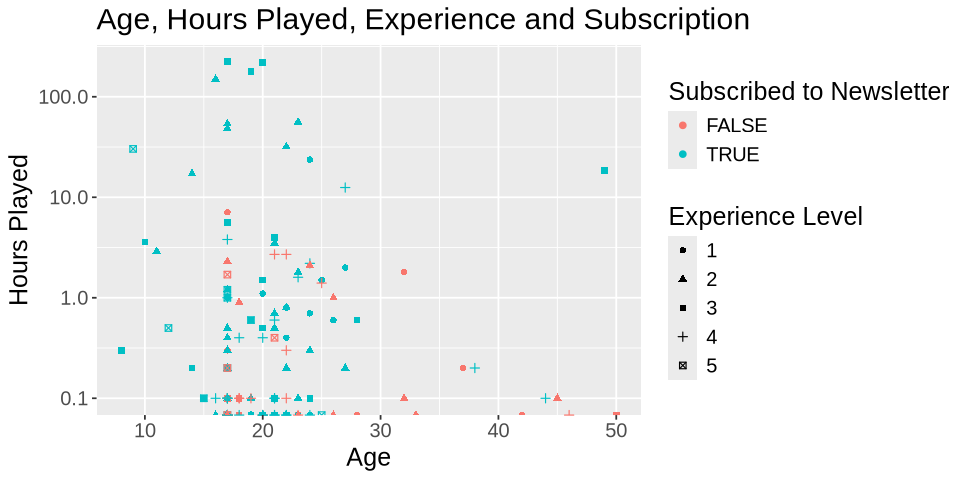

In [22]:
options(repr.plot.width = 8, repr.plot.height = 4)
all_pred_scatter

To determine whether the variables for age, hours played, and experience can predict subscription status, and to visualize the relationship between the variables, we plotted the data using a scatter plot. However, the plot yielded no obvious trends among the variables—whether or not a player is subscribed to the newsletter is evenly distributed between the variables. It can be observed that there is a weak negative correlation between variable `Age` and `played_hours` but the results for subcription and experience level is a little more ambiguous. 

To further investigate how each variable predicts subscription status, we plotted each predictor variable individually against `subscribe` using histograms to visualize the distribution of players who have subscribed or not. 

##### Hours Played vs Subscription 

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


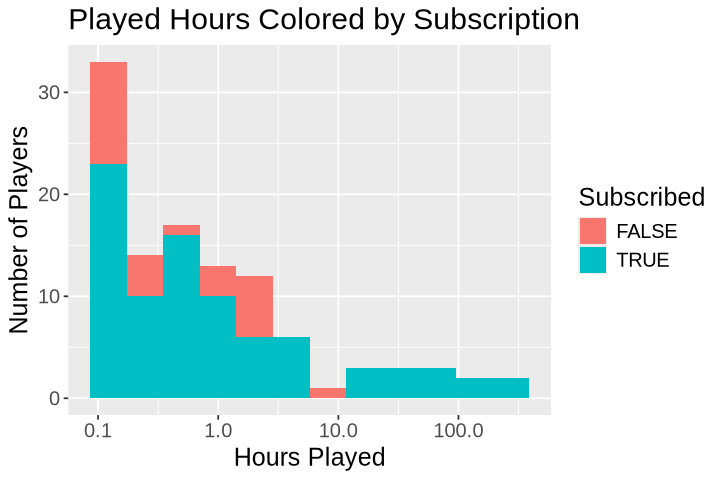

In [20]:
options(repr.plot.width = 6, repr.plot.height = 4)
hours_his

By plotting hours played, it can be seen that players with fewer hours played are less likely to subscribe while players with more hours played are more likely to subscribe. This is expected as it is expected that players who play the game more often would be more interested in the game and would therefore also be more inclined to subscribe to the newsletter. 

##### Age vs Subscription

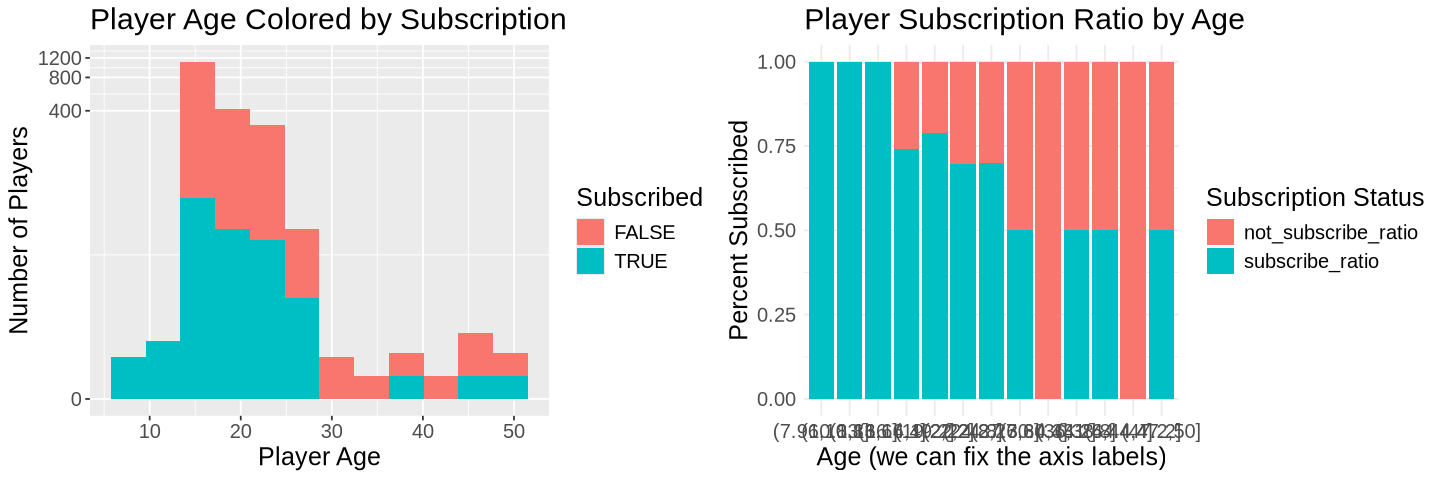

In [19]:
options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(age_his, age_ratio, ncol  = 2) 

By plotting the player’s age on a histogram, it appears that younger players are more likely to subscribe than older players. To further confirm this trend, the ratio of subscribers to non-subscribers was plotted by age. From this graph, it can be determined that younger players have a higher ratio of subscribing to the newsletter. These results also align with expectations as it is expected that younger players would be more interested in the game and therefore subscribe to the newsletter. 


##### Experience vs Subscription 

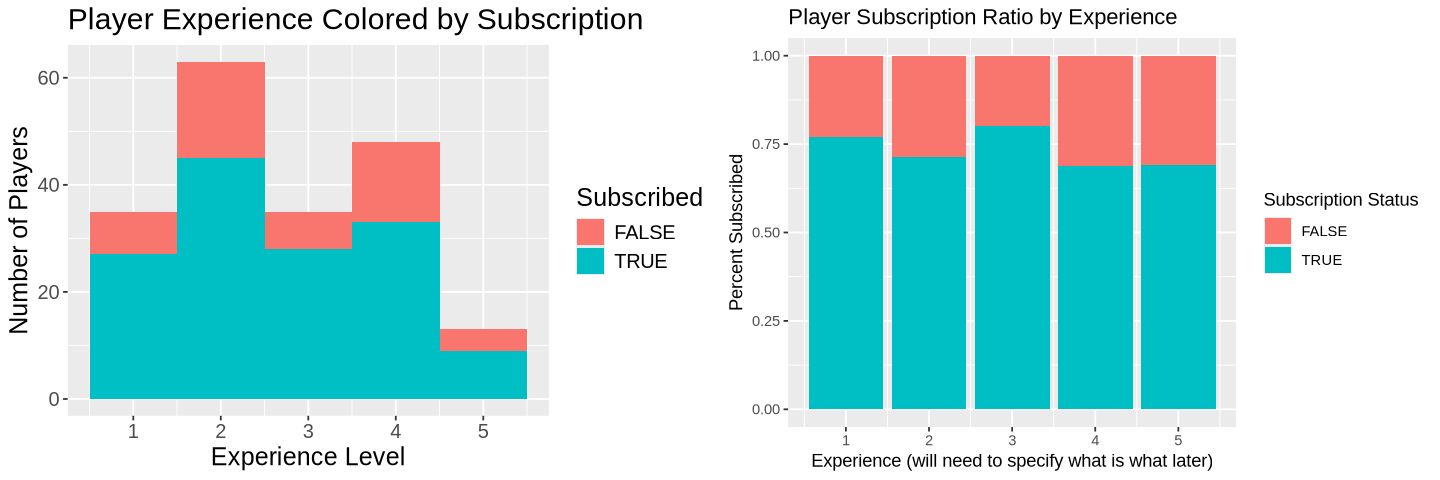

In [23]:
options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(experience_his, experience_ratio, ncol  = 2) 

By plotting the experience of players, no clear trend can be obtained. Players of all experience levels subscribed to the newsletters at a similar ratio. This is unexpected as it was expected that players with more experience would be more engaged in the game and therefore more likely to subscribe. 


#### Outcome
Overall, by plotting each predictor individually, it can be determined that players who play more hours of the game and who are younger are more likely to subscribe to the newsletter, making the variables played_hours and age somewhat useful predictors of subscribe. Experience on the other hand, yielded no relationship with subscription suggesting that it is not a good predictor for subscription. This helps explain why our KNN classification model has an accuracy of about ***72.5%***—not all the predictors had strong relationships with Subscribe. 


### Implications
The implication of these results could be useful for marketing strategies. By understanding what type of players are more likely to subscribe to the newsletter, allows the content of the newsletter to be better tailored for its audience. Additionally, with this information, different marketing strategies would be employed to increase subscription rates for groups who are less likely to subscribe. 

Based on our analysis, it can be understood that every recorded player ages *8-13* are subscribed to the newsletter with teens having the highest age group ratio of doing so. Those that play over *5* hours are almost always likely to subscribe to the newsletter as well. This communicates that younger players and those with more time to play Minecraft are more likely to subscribe to the newletter. 


### Future questions
- What other factors can predict whether or not a player will be subscribed to the newsletter? 
- What kind of incentives could be used to increase subscription rates? 
- … 
